In [48]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelPropagation, LabelSpreading 
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
train = pd.read_csv('train.csv', index_col=0, parse_dates=['birthday', 'date'])
test = pd.read_csv('test.csv', index_col=0, parse_dates=['birthday', 'date'])

In [50]:
from ast import literal_eval

train['target'] = train['target'].apply(lambda x: literal_eval(x)[0] if x is not np.nan else x)
test['target'] = test['target'].apply(lambda x: literal_eval(x)[0] if x is not np.nan else x)

In [51]:
train['service_lemm'] = train['service_lemm'].fillna('')
test['service_lemm'] = test['service_lemm'].fillna('')

In [52]:
num_cols = ['num', 'birthday_year']
cat_cols = ['service_class']
text_cols = ['service_lemm']

In [57]:
train_classes = train['target'].sort_values().unique()
test_classes = test['target'].sort_values().unique()
classes = np.unique(train_classes.tolist() + test_classes.tolist())
mapping = dict(zip(classes, range(len(classes))))
mapping

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'V': 20,
 'W': 21,
 'Y': 22,
 'Z': 23,
 'nan': 24}

In [58]:
y_train = train['target'].map(mapping).fillna(-1).astype(int)

In [59]:
y_test = test['target'].map(mapping)

In [60]:
X_cols = num_cols + cat_cols + text_cols
X_train = train[X_cols]
X_test = test[X_cols]

In [61]:
num_indices = np.argwhere(X_train.columns.isin(num_cols)).flatten()
cat_indices = np.argwhere(X_train.columns.isin(cat_cols)).flatten()
text_indices = np.argwhere(X_train.columns.isin(text_cols)).flatten()

In [62]:
X_train.head()

,num,birthday_year,service_class,service_lemm
141239,1,1971,5002,гальванизация электрофорез лекарственный вещество
96146,1,1971,3410,цитологический исследование соскоб эндоцервикс...
113064,1,1971,4100,определение функция внешний дыхание фвд
150108,1,1982,7100,покрытие 1 го зуб фторсодержащий препарат
129272,1,1968,4111,экг 12 ти отведение снятие расшифровка


In [67]:
def test_model(pl):
    y_pred = pl.predict(X_test.values)
    print(classification_report(y_test, y_pred, zero_division=0, target_names=test_classes))
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        square=True, annot=True, 
        fmt='d', xticklabels=test_classes, 
        yticklabels=test_classes
    );

## Label Spreading

In [64]:
pl = Pipeline([
    ('preprocess', FeatureUnion([
        ('num', Pipeline([
            ('select', FunctionTransformer(lambda X: X[:, num_indices], validate=False)),
            ('scaler', StandardScaler())
        ])),
        ('cat', Pipeline([
            ('select', FunctionTransformer(lambda X: X[:, cat_indices], validate=False)),
            ('onehot', OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'))
        ])),
        ('text', Pipeline([
            ('select', FunctionTransformer(lambda X: X[:, text_indices[0]], validate=False)),
            ('tfidf', TfidfVectorizer(min_df=50)),
            ('toarray', FunctionTransformer(lambda X: X.toarray(), validate=False, accept_sparse=True))
        ]))
    ])),
    ('pca', PCA(100)),
    ('model', LabelSpreading(kernel='knn', n_jobs=-1))
])

In [65]:
%%time
pl = pl.fit(X_train.values, y_train.values)

CPU times: user 1min 43s, sys: 1.63 s, total: 1min 44s
Wall time: 15.2 s


/home/aminought/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: divide by zero encountered in true_divide
  self.label_distributions_ /= normalizer
/home/aminought/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


              precision    recall  f1-score   support

           A       0.01      0.06      0.01       116
           B       0.23      0.13      0.17       249
           C       0.17      0.07      0.10        15
           D       0.20      0.09      0.13       825
           E       0.71      0.65      0.68      1711
           F       0.43      0.11      0.17        28
           G       0.36      0.27      0.31       785
           H       0.84      0.80      0.82      1693
           I       0.48      0.50      0.49      2294
           J       0.56      0.64      0.60      3418
           K       0.75      0.77      0.76      5258
           L       0.41      0.37      0.39       718
           M       0.70      0.68      0.69      4223
           N       0.72      0.78      0.75      4227
           O       0.00      0.00      0.00         2
           P       0.00      0.00      0.00         1
           Q       0.00      0.00      0.00        13
           R       0.08    

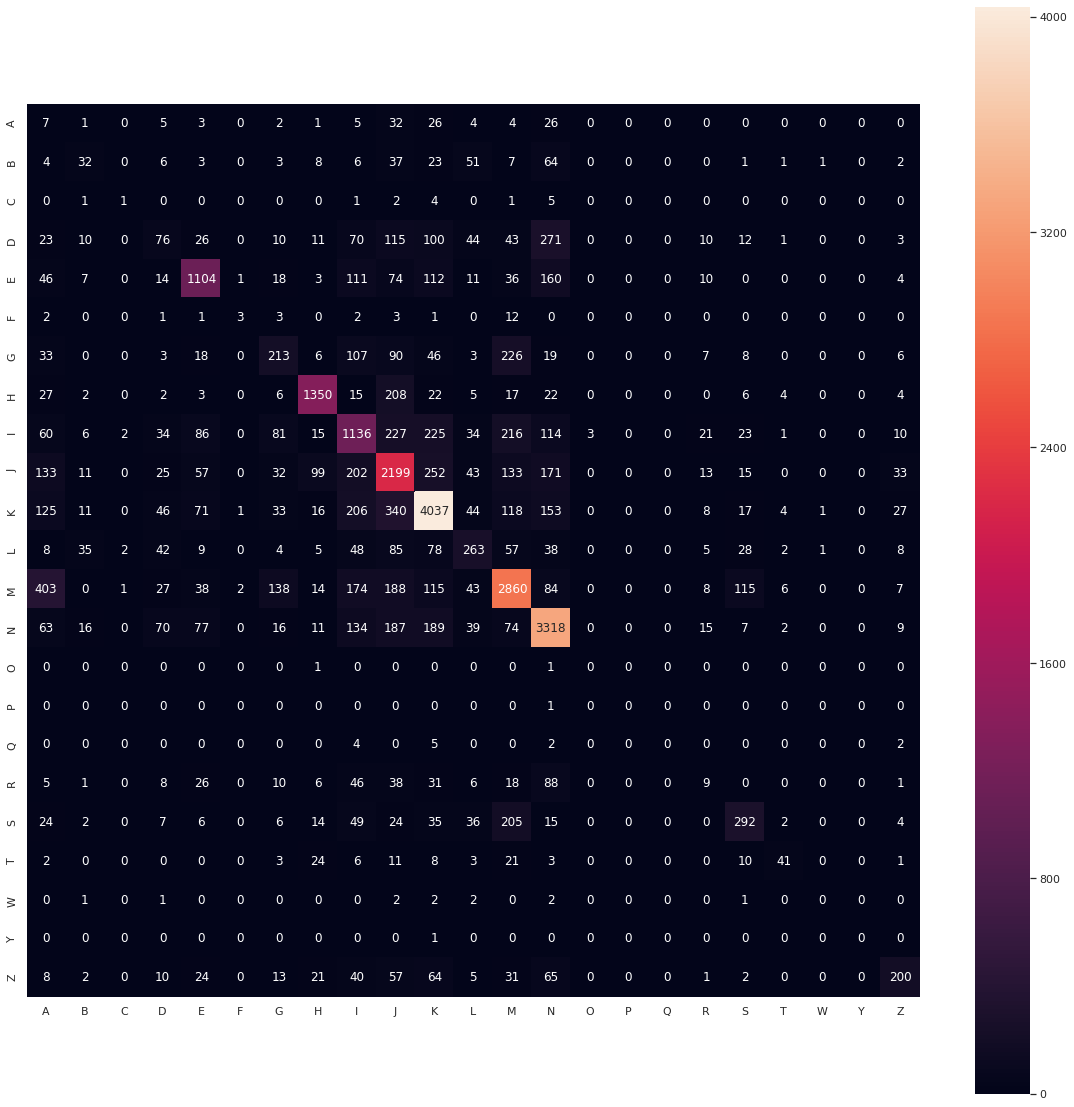

In [68]:
test_model(pl)